<a href="https://colab.research.google.com/github/jerrymart/Machine-Learning-Projects/blob/main/Linear_Regression_Factors_Affecting_Revenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Case

Investigate "what factors/variables affect the performance of revenue"

Our aim is to go back to the business and make suggestions about how to generate more revenue

Make Revenue predictions given specific variable values


In [3]:
# Packages / libraries
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score,accuracy_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_val_score

#Regressors
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor


%matplotlib inline


# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(12,10)})

## Loading the Raw Data

In [5]:
raw_data = pd.read_csv('/content/MarketingRawData.csv')

In [7]:
raw_data.head()

,Date,Week,Week_ID,Month,Month_ID,Year,Day_Name,Visitors,Revenue,Marketing Spend,Promo
0,09/11/2020,46.0,34.0,11.0,11.0,2020.0,Monday,707.0,465.0,651.375,No Promo
1,10/11/2020,46.0,34.0,11.0,11.0,2020.0,Tuesday,1455.0,10386.0,1298.250,Promotion Red
2,11/11/2020,46.0,34.0,11.0,11.0,2020.0,Wednesday,1520.0,12475.0,1559.375,Promotion Blue
3,12/11/2020,46.0,34.0,11.0,11.0,2020.0,Thursday,1726.0,11712.0,1801.750,No Promo
4,13/11/2020,46.0,34.0,11.0,11.0,2020.0,Friday,2134.0,10000.0,2614.500,No Promo


In [8]:
# print the shape
print(raw_data.shape)

(185, 11)


## Data Preprocessing

### Exploratory Data Analysis

In [9]:
# Checking for null values

raw_data.isnull().sum()

Date               0
Week               3
Week_ID            3
Month              3
Month_ID           3
Year               3
Day_Name           3
Visitors           3
Revenue            3
Marketing Spend    3
Promo              3
dtype: int64

In [11]:
# Visualize the NULL observations
raw_data[raw_data['Week'].isnull()]

,Date,Week,Week_ID,Month,Month_ID,Year,Day_Name,Visitors,Revenue,Marketing Spend,Promo
182,10/05/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,11/05/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,12/05/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Deleting the NULL values
raw_data = raw_data.dropna(subset = ['Week'])  #raw_data.dropna() will drop all na in the data

# Printing the shape
raw_data.shape

# Visualize the NULL observations
raw_data.isnull().sum()

Date               0
Week               0
Week_ID            0
Month              0
Month_ID           0
Year               0
Day_Name           0
Visitors           0
Revenue            0
Marketing Spend    0
Promo              0
dtype: int64

In [13]:
# Investigate all the elements whithin each Feature 

for column in raw_data:
    unique_vals = np.unique(raw_data[column])
    nr_values = len(unique_vals)
    if nr_values < 10:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature Date :182
The number of values for feature Week :28
The number of values for feature Week_ID :28
The number of values for feature Month :7 -- [1.000000 2.000000 3.000000 4.000000 5.000000 11.000000 12.000000]
The number of values for feature Month_ID :7 -- [11.000000 12.000000 13.000000 14.000000 15.000000 16.000000 17.000000]
The number of values for feature Year :2 -- [2020.000000 2021.000000]
The number of values for feature Day_Name :7 -- ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
The number of values for feature Visitors :175
The number of values for feature Revenue :181
The number of values for feature Marketing Spend :182
The number of values for feature Promo :3 -- ['No Promo' 'Promotion Blue' 'Promotion Red']


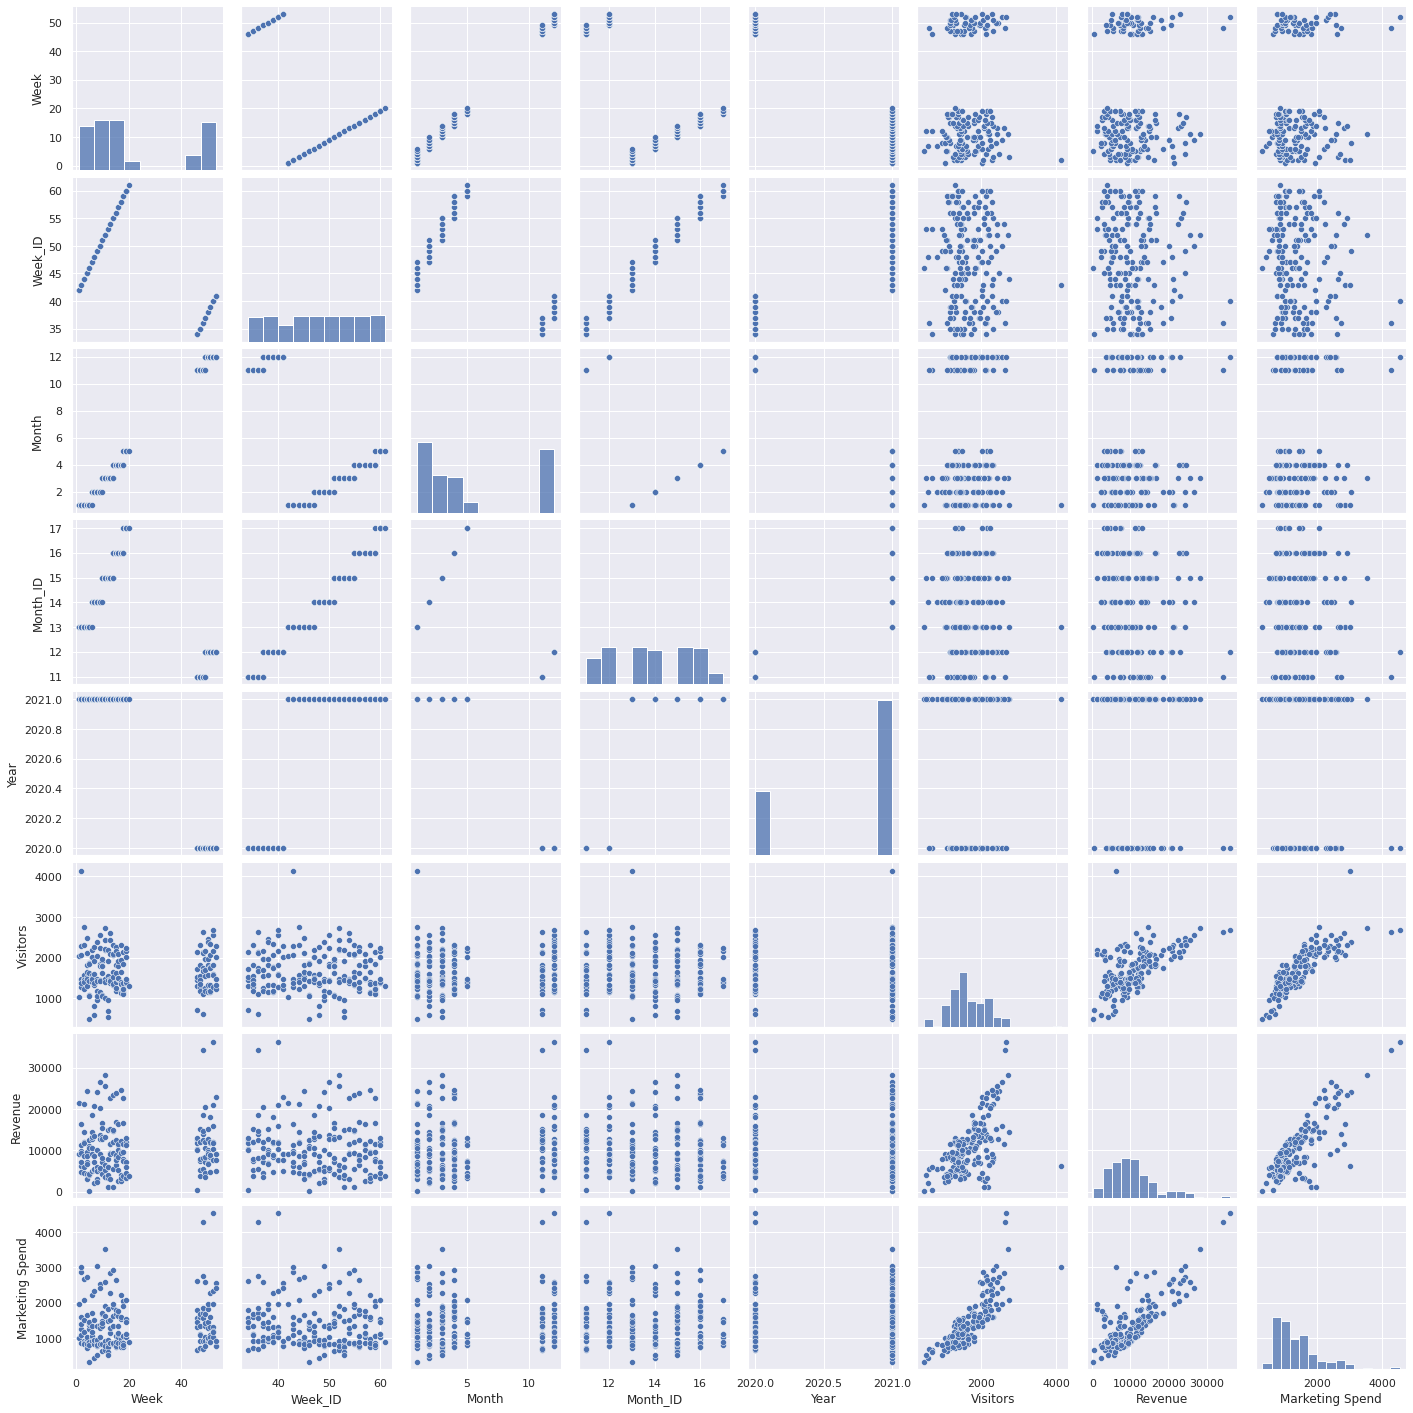

In [14]:
# Visualize the data using seaborn Pairplots

g = sns.pairplot(raw_data)

# Notes: Do not run this on a big dataset. Filter the columns first

In [15]:
raw_data.columns

Index(['Date', 'Week', 'Week_ID', 'Month', 'Month_ID', 'Year', 'Day_Name',
       'Visitors', 'Revenue', 'Marketing Spend', 'Promo'],
      dtype='object')

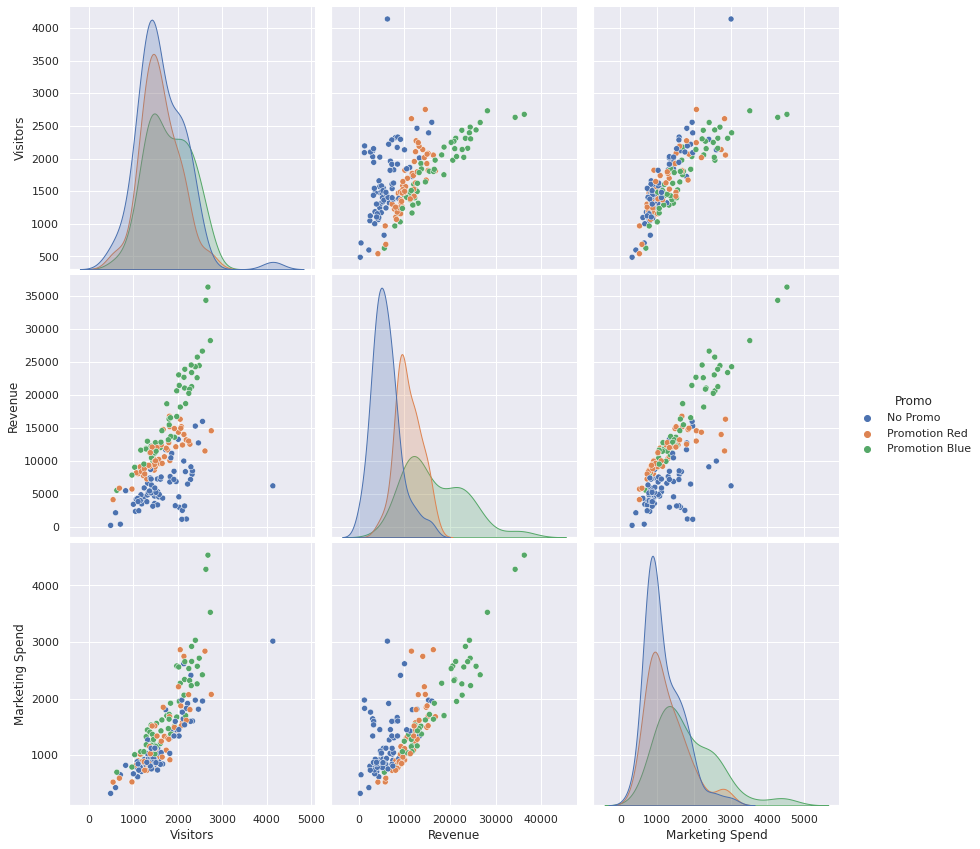

In [21]:
# Visualising a Subset of our data - important features as shown in by plot above
#there are good correlations on feature [Visitors', 'Revenue', 'Marketing Spend]

g = sns.pairplot(raw_data[['Visitors', 'Revenue', 'Marketing Spend', 'Promo']], hue = 'Promo', height = 4)

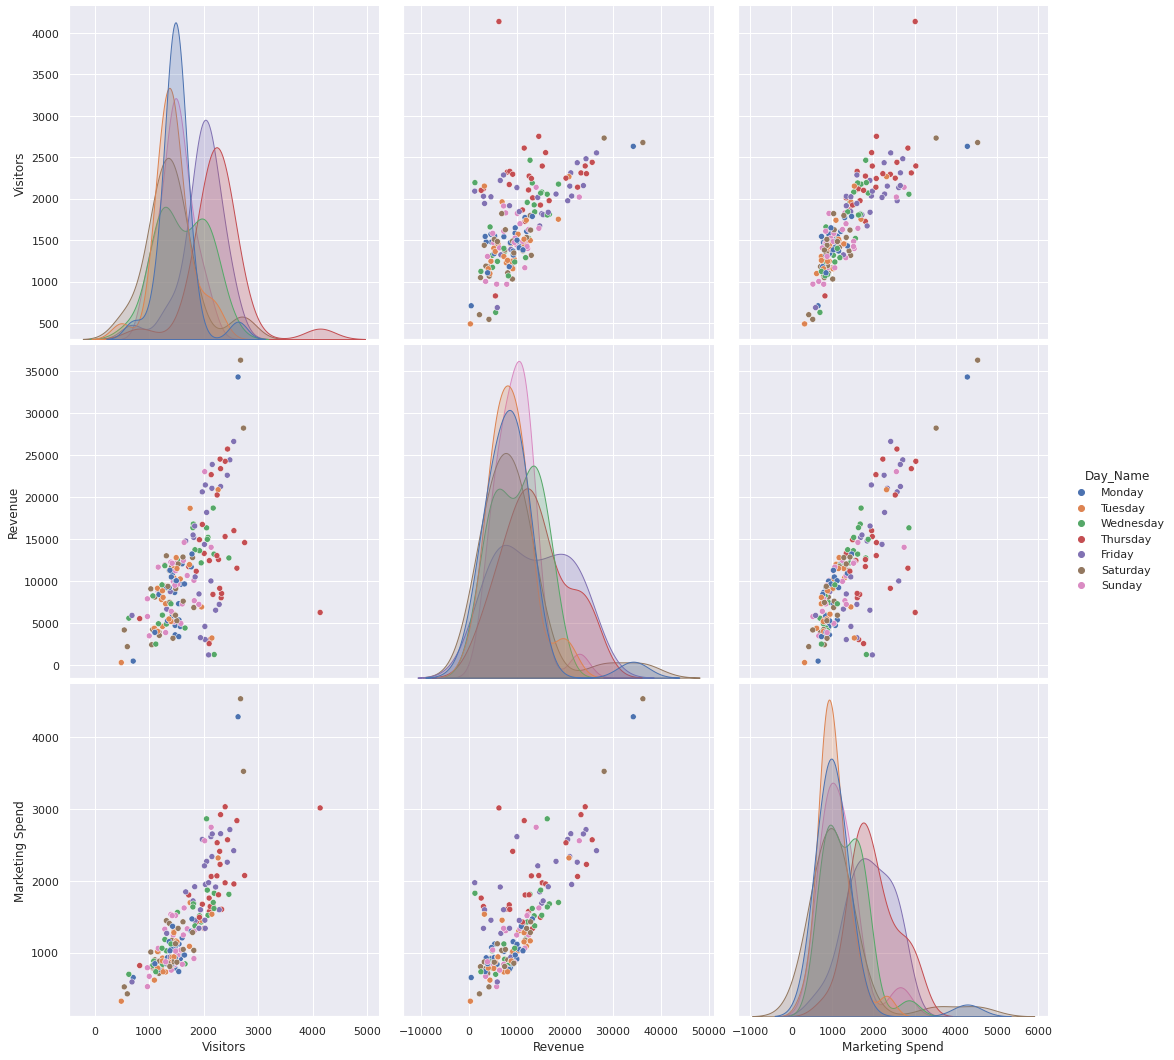

In [22]:
# Visualising a Subset of our data - important features

g = sns.pairplot(raw_data[['Visitors', 'Revenue', 'Marketing Spend', 'Day_Name']], hue = 'Day_Name', height = 5)

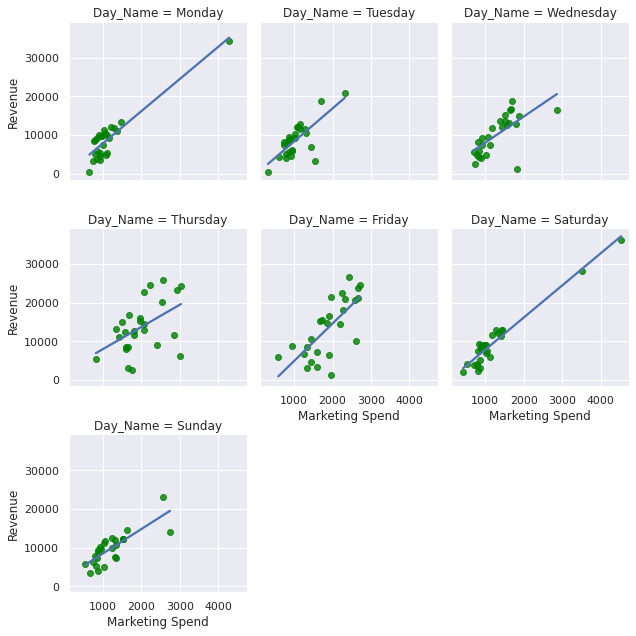

In [23]:
# Visualising a Subset of our data - important features

g = sns.lmplot(x = 'Marketing Spend', y = 'Revenue', data = raw_data, col = 'Day_Name', col_wrap = 3, height = 3, 
              scatter_kws = {'color':'green'}, ci = False)

In [ ]:
# Spot-Check Algorithms
models = []

models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))
models.append(('SVM', XGBRegressor()))

#Evaluate each model in turn
outputs = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy').mean()
    outputs.append(cv_results)
    names.append(name)
    print("Accuracy: %s: %f (%f)" % (name, cv_results, cv_results.std()))